# Call all libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.models  import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

%matplotlib inline
print('Done !!!')

Done !!!


# Load Split and Scale Dataset

In [2]:

def load_split_scale():
  
#     file_dir = Path('/content/drive/My Drive/Data_Science/projects/predictive_maintenance/data')
    file_dir = Path('/Users/khan_m_a/Google Drive/Data_Science/projects/predictive_maintenance/data')


    df_one_hot = pd.read_csv( file_dir / 'df_one_hot.csv',
                 parse_dates = True, index_col = 'date',
                 delimiter = ',')
    print('Loaded Dateset')

    # make X and y 
    X = df_one_hot.drop('failure', axis =1).values
    y = df_one_hot.failure.values

    # check sizes
    print('X and y sizes are :', X.shape, y.shape)

    # make statify = y for imbalanced dataset
    X_train1, X_test, y_train1, y_test = train_test_split(X, y, 
                              test_size = 0.2, stratify = y )
    
    X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, 
                              test_size = 0.2, stratify =  y_train1)
    
    print('X_train, X_val, and X_test sizes are ', X_train.shape, X_val.shape, X_test.shape )
    
    # check if failure is equally distribute.
    print('failures in train, val, and test are :', y_train.sum(), y_val.sum(), y_test.sum())
    

    # Apply standardization to X_train and X_test
    # scaler = MinMaxScaler()
    scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()
    X_train = scaler1.fit_transform(X_train) # fit and transform on X_train
    X_val = scaler2.fit_transform(X_val) # fit and transform X_val
    X_test = scaler3.fit_transform(X_test) # fit and transform X_test
    
    # remove all point above and below 5   
    X_train = np.clip(X_train, -5, 5)
    X_test = np.clip(X_test, -5, 5)
    X_val = np.clip(X_val, -5, 5)
    
    # check scaled 
    print('Train scaled', X_train[0:3], y[0:3])
    print('Val scaled', X_val[0:3], y[0:3])
    print('Test scaled', X_test[0:3], y[0:3])
    
    return df_one_hot, X_train, X_val, X_test, y_train, y_val, y_test


df_one_hot, X_train, X_val, X_test, y_train, y_val, y_test = load_split_scale()
print('Done !!!')

Loaded Dateset
X and y sizes are : (124494, 1177) (124494,)
X_train, X_val, and X_test sizes are  (79676, 1177) (19919, 1177) (24899, 1177)
failures in train, val, and test are : 68 17 21
Train scaled [[-0.97369352 -0.07238345 -0.0527836  ... -0.02652057 -0.02652057
  -0.02652057]
 [ 0.39424768 -0.07238345 -0.0527836  ... -0.02652057 -0.02652057
  -0.02652057]
 [-0.31587299 -0.07238345 -0.0527836  ... -0.02652057 -0.02652057
  -0.02652057]] [0 0 0]
Val scaled [[-0.58162403 -0.07780312 -0.04679123 ... -0.02004465 -0.02004465
  -0.02922645]
 [-0.30806979  0.31390308 -0.04679123 ... -0.02004465 -0.02004465
  -0.02922645]
 [-0.61658652 -0.07780312 -0.04679123 ... -0.02004465 -0.02004465
  -0.02922645]] [0 0 0]
Test scaled [[ 1.11143262 -0.07232987 -0.07399279 ... -0.02835297 -0.02835297
  -0.02004455]
 [-0.30671014 -0.07232987 -0.07399279 ... -0.02835297 -0.02835297
  -0.02004455]
 [-1.11532076 -0.07232987 -0.07399279 ... -0.02835297 -0.02835297
  -0.02004455]] [0 0 0]
Done !!!


In [3]:
failed = df_one_hot['failure'].sum()
not_failed =  df_one_hot.shape[0] - failed
print('Total num of failures {} out of {}'.format(df_one_hot['failure'].sum(), df_one_hot.shape[0]))
print('Percentage of failures = {0:.2f} %'.format(100 * df_one_hot['failure'].sum() / df_one_hot.shape[0]))

Total num of failures 106 out of 124494
Percentage of failures = 0.09 %


In [4]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
failed
output_bias = np.log([failed / not_failed])
print(output_bias)

[-7.0677219]


# Deep Learning Models

In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

#http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines


In [206]:
# Create a dense model with class_weights

'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''

metrics_nn = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'), # true samples/ total samples
      keras.metrics.Precision(name='precision'), # TP /(TP + FP)
      keras.metrics.Recall(name='recall'), # TP /(TP + FN)
#       keras.metrics.AUC(name='auc')
        ]

def my_nn_model_weight(output_bias =0 ):
  output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
                  keras.layers.Input(shape = ( X_train.shape[1])),#, name = ' input_layer'),
                  keras.layers.Dense(10, activation = 'relu'),#,kernel_regularizer=l2(0.0001),name = 'layer1'),
                  keras.layers.Dropout(0.1),                  
                  keras.layers.Dense(5, activation = 'tanh'),#'relu',name = 'layer2'),
                  keras.layers.Dropout(0.1),
                  keras.layers.Dense(1, activation = 'sigmoid', 
                                     bias_initializer = output_bias, name = 'final_layer')

                           ])
  model.compile( optimizer = tf.keras.optimizers.Adam(lr = 0.005, decay = 0.0000001),
                loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                metrics  = metrics_nn#['accuracy']
                
                )
  return model

In [207]:
# Class weight 
failed = df_one_hot['failure'].sum()
not_failed =  df_one_hot.shape[0] - failed
# total/2 will apply equal weight
weight_failed = (1/failed) * df_one_hot.shape[0]/2
weight_not_failed = (1/not_failed) * df_one_hot.shape[0]/2
class_weight = {0: weight_failed / 1 , 1: weight_not_failed * 1}

In [268]:
tf.keras.backend.clear_session() # initialize the model
model_weighted = None

# create a new model
model_weighted = my_nn_model_weight(output_bias)
model_weighted.summary()
# layer1 = (1177 * 32) + 32 = 37696
# layer2 = (32 * 10 ) + 10 = 330
#final_layer = (10 * 1 ) + 1 = 11


#fit the model with class_weight
EPOCHS = 10
BATCH_SIZE = 32

history_weighted = model_weighted.fit(X_train, y_train, class_weight = class_weight,
                    batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = 0, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                11780     
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
final_layer (Dense)          (None, 1)                 6         
Total params: 11,841
Trainable params: 11,841
Non-trainable params: 0
_________________________________________________________________


In [269]:
# model_weighted.weights

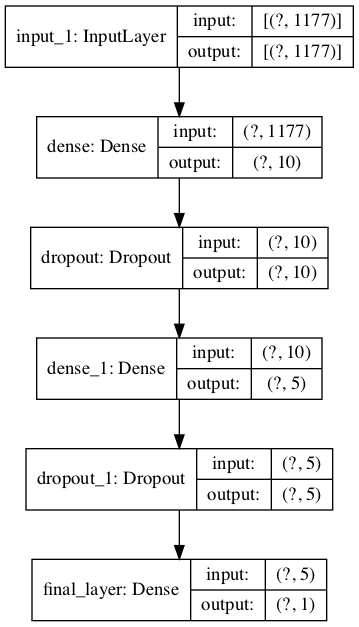

In [270]:
plot_model(model_weighted, show_shapes = True)

In [271]:
# Evaluate
score_tr = model_weighted.evaluate(X_train, y_train, verbose = 2)
score_val = model_weighted.evaluate(X_val, y_val, verbose = 2)
score_te = model_weighted.evaluate(X_test, y_test, verbose = 2)
print('Test loss', score_te[0])
print('Val loss', score_val[0])
print('Test loss', score_te[0])

2490/2490 - 2s - loss: 0.0117 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 79608.0000 - fn: 68.0000 - accuracy: 0.9991 - precision: 0.0000e+00 - recall: 0.0000e+00
623/623 - 1s - loss: 0.0123 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 19902.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.0000e+00 - recall: 0.0000e+00
779/779 - 1s - loss: 0.0120 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24878.0000 - fn: 21.0000 - accuracy: 0.9992 - precision: 0.0000e+00 - recall: 0.0000e+00
Test loss 0.011982164345681667
Val loss 0.012312865816056728
Test loss 0.011982164345681667


In [272]:
hist = pd.DataFrame(history_weighted.history)
hist.tail(3)

,loss,tp,fp,tn,fn,accuracy,precision,recall,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall
7,0.006399,0.0,0.0,79608.0,68.0,0.999147,0.0,0.0,0.012680,0.0,0.0,19902.0,17.0,0.999147,0.0,0.0
8,0.006436,0.0,0.0,79608.0,68.0,0.999147,0.0,0.0,0.012119,0.0,0.0,19902.0,17.0,0.999147,0.0,0.0
9,0.006214,0.0,0.0,79608.0,68.0,0.999147,0.0,0.0,0.012313,0.0,0.0,19902.0,17.0,0.999147,0.0,0.0


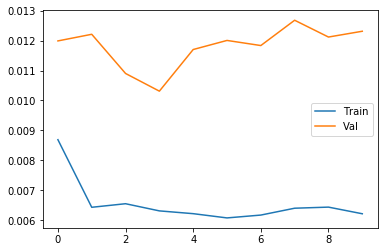

In [273]:
# # plot the loss

plt.plot(history_weighted.epoch,  history_weighted.history['loss'],  label='Train')
plt.plot(history_weighted.epoch,  history_weighted.history['val_loss'],  label='Val')

plt.legend()
plt.show()

In [274]:
# function for plotting

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
# plot_roc_curve (fpr,tpr) 


In [275]:
# predict in probability
yhat_train = model_weighted.predict(X_train)
yhat_val = model_weighted.predict(X_val)
yhat_test = model_weighted.predict(X_test)

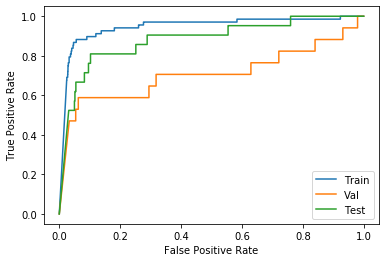

In [276]:
# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

fpr_mod_tr, tpr_mod_tr, _ = roc_curve(y_train, yhat_train)
plt.plot(fpr_mod_tr, tpr_mod_tr, label = 'Train')
fpr_mod_val, tpr_mod_val, _ = roc_curve(y_val, yhat_val)
plt.plot(fpr_mod_val, tpr_mod_val, label = 'Val')
fpr_mod, tpr_mod, _ = roc_curve(y_test, yhat_test)
plt.plot(fpr_mod, tpr_mod, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [277]:
# calculated ROC AUC for Train
# score = roc_auc_score(y_train, yhat_train)
print('ROC AUC for Train is : ', roc_auc_score(y_train, yhat_train))
print('ROC AUC for Val is : ', roc_auc_score(y_val, yhat_val))
print('ROC AUC for Test is : ', roc_auc_score(y_test, yhat_test))

ROC AUC for Train is :  0.9466572787541305
ROC AUC for Val is :  0.7080695407496733
ROC AUC for Test is :  0.8827784349530471


In [16]:
cm_prob_threshold = 0.5

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Text(0.5, 15.0, 'Predicted label')

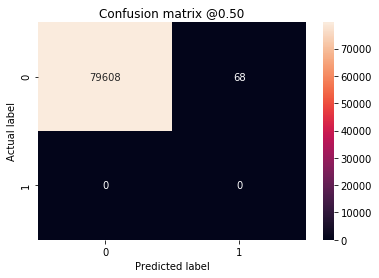

In [17]:
# make prediction on train dataset
yhat_train = model_weighted.predict_classes(X_train, batch_size = BATCH_SIZE)
# yhat_train = np.argmax(model.predict(X_train), axis = -1)

# confusion matrix
conf_matrix_tr = tf.math.confusion_matrix(yhat_train > cm_prob_threshold, y_train )

sns.heatmap(conf_matrix_tr, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 15.0, 'Predicted label')

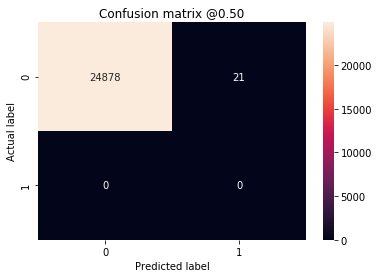

In [19]:
# make prediction on test dataset

yhat_test = model_weighted.predict_classes(X_test, batch_size = BATCH_SIZE)

conf_matrix_te = tf.math.confusion_matrix(yhat_test >cm_prob_threshold, y_test )
sns.heatmap(conf_matrix_te, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 15.0, 'Predicted label')

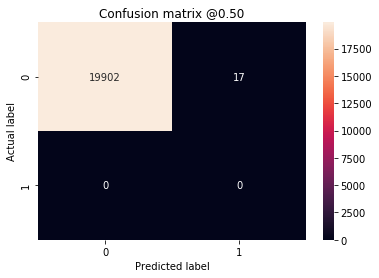

In [18]:
# make prediction on val dataset

yhat_val = model_weighted.predict_classes(X_val, batch_size = BATCH_SIZE)

conf_matrix_val = tf.math.confusion_matrix(yhat_val > cm_prob_threshold, y_val )
sns.heatmap(conf_matrix_val, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

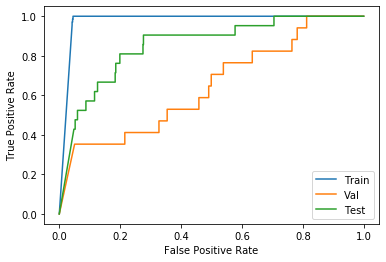

ROC AUC for Train is :  0.977962235542393
ROC AUC for Val is :  0.6453622751482263
ROC AUC for Test is :  0.85431285626237
